In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
import eagerpy as ep
import h5py

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [4]:
from numpy.lib import recfunctions as rfn
import torch

def torch_from_structured(tracks):
    tracks_np = rfn.structured_to_unstructured(tracks, copy=True, dtype=np.float32)
    return torch.from_numpy(tracks_np).float()

def structered_from_torch(tracks_torch, dtype):
    return rfn.unstructured_to_structured(tracks_torch.cpu().numpy(), dtype=dtype)

### Dataset import
First of all we load the `edep-sim` output. For this sample we need to invert $z$ and $y$ axes.

In [5]:
with h5py.File('module0_corsika.h5', 'r') as f:
    tracks = np.array(f['segments'])

x_start = np.copy(tracks['x_start'] )
x_end = np.copy(tracks['x_end'])
x = np.copy(tracks['x'])

tracks['x_start'] = np.copy(tracks['z_start'])
tracks['x_end'] = np.copy(tracks['z_end'])
tracks['x'] = np.copy(tracks['z'])

tracks['z_start'] = x_start
tracks['z_end'] = x_end
tracks['z'] = x

selected_tracks = tracks[30:40]
selected_tracks_torch = torch_from_structured(np.copy(selected_tracks))

## Simulation
To flexibly keep track of parameters/gradients, simulations are housed in a class `sim_with_grad`. This is derived from class versions of all the other modules. Parameters are housed in `consts`, with method `track_gradients` to promote the constants to `requires_grad=True` PyTorch tensors.

In [6]:
from larndsim.sim_with_grad import sim_with_grad

Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.pixel_trim_dac using bits (0, 512)
	<function _list_property at 0x166e6a1f0>((<class 'int'>, 0, 31, 64, 8)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.threshold_global using bits (512, 520)
	<function _basic_property at 0x166e6a160>((<class 'int'>, 0, 255)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_gain using bits (520, 521)
	<function _compound_property at 0x166e6a280>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_bypass_enable using bits (521, 522)
	<function _compound_property at 0x166e6a280>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.bypass_caps_en using bits (522, 523)
	<function _c

## The simulation
Following the flow of the simulation chain, define a function which takes in the `sim_with_grad` object, runs whatever pieces of the simulation, and returns desired output.

In [7]:
from larndsim.sim_with_grad import sim_with_grad

/Users/seangasiorowski/miniforge3/envs/cenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Here we build a map between tracks and event IDs (no param dependence, so np should be ok)
unique_eventIDs = np.unique(selected_tracks['eventID'])
event_id_map = np.searchsorted(unique_eventIDs,np.asarray(selected_tracks['eventID']))
event_id_map_torch = torch.from_numpy(event_id_map)

In [9]:
def all_sim(sim, selected_tracks, fields, event_id_map):
    selected_tracks_quench = sim.quench(selected_tracks, sim.birks, fields=fields)
    selected_tracks_drift = sim.drift(selected_tracks_quench, fields=fields)

    active_pixels_torch, neighboring_pixels_torch, n_pixels_list_ep = sim.get_pixels(selected_tracks_drift,
                                                                                     fields=fields)

    track_starts_torch, max_length_torch = sim.time_intervals(event_id_map_torch, 
                                                              selected_tracks_drift, 
                                                              fields=fields)

    signals_ep = sim.tracks_current(neighboring_pixels_torch, selected_tracks_drift, 
                                          max_length_torch,
                                          fields=fields)
    
    unique_pix_torch = torch.empty((0, 2))
    pixels_signals_torch = torch.zeros((len(unique_pix_torch), len(sim.time_ticks)*3))

    shapes_torch = neighboring_pixels_torch.shape
    joined_torch = neighboring_pixels_torch.reshape(shapes_torch[0]*shapes_torch[1], 2)

    this_unique_pix_torch = torch.unique(joined_torch, dim=0)
    this_unique_pix_torch = this_unique_pix_torch[(this_unique_pix_torch[:,0] != -1) & (this_unique_pix_torch[:,1] != -1),:]
    unique_pix_torch = torch.cat((unique_pix_torch, this_unique_pix_torch),dim=0)

    this_pixels_signals_torch = torch.zeros((len(this_unique_pix_torch), len(sim.time_ticks)*3))
    pixels_signals_torch = torch.cat((pixels_signals_torch, this_pixels_signals_torch), dim=0)

    pixel_index_map_torch = torch.full((selected_tracks.shape[0], neighboring_pixels_torch.shape[1]), -1)
    compare_torch = (neighboring_pixels_torch[..., np.newaxis, :] == unique_pix_torch)

    indices_torch = torch.where(torch.logical_and(compare_torch[..., 0], compare_torch[...,1]))
    pixel_index_map_torch[indices_torch[0], indices_torch[1]] = indices_torch[2]
    
    pixels_signals_torch = sim.sum_pixel_signals(pixels_signals_torch,
                                                 signals_ep,
                                                track_starts_torch,
                                                pixel_index_map_torch)
    
    currents = pixels_signals_torch.sum(dim=1)*sim.t_sampling/sim.e_charge

    return currents

In [10]:
# Update parameters for training loop
def update_grad_param(sim, name, value):
    setattr(sim, name, value)
    sim.track_gradients([name])

## Experiment: pseudo-data
1. Construct dataset with one set of parameters
2. Initialize parameters to something else
3. See if we can recover default parameters

In [11]:
from larndsim.sim_with_grad import sim_with_grad

In [12]:
#Simulate with defaults: in particular, eField == 0.5
sim_default = sim_with_grad()
sim_default.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
out05 = all_sim(sim_default, selected_tracks_torch, selected_tracks.dtype.names, event_id_map)

/Users/seangasiorowski/miniforge3/envs/cenv/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [13]:
#Setup simulation object for training
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

In [40]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

#Initialize eField to different value (0.55)
eField_init = 0.3

update_grad_param(sim, "eField", eField_init)
optimizer = torch.optim.SGD([sim.eField], lr=3e-8, momentum=0.1)

training_step_eFields = []
training_step_currents = []
#Training loop
for epoch in range(20):
    optimizer.zero_grad()
    
    #First, set eField parameter 
    #update_grad_param(sim, "eField", eField)
    
    #Simulate with that parameter and get output
    output = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map)
    
    #Calc loss between simulated and target + backprop
    loss = loss_fn(output, out05)
    loss.backward()
    
    print(sim.eField.grad)
    optimizer.step()
    print(sim.eField)
    training_step_eFields.append(sim.eField.detach())
    training_step_currents.append(output.detach())

tensor(-5538136.)
tensor(0.4661, requires_grad=True)
tensor(-304250.7500)
tensor(0.4919, requires_grad=True)
tensor(-63255.7266)
tensor(0.4964, requires_grad=True)
tensor(-27711.1230)
tensor(0.4976, requires_grad=True)
tensor(-17866.3359)
tensor(0.4983, requires_grad=True)
tensor(-12788.5527)
tensor(0.4988, requires_grad=True)
tensor(-9383.9551)
tensor(0.4991, requires_grad=True)
tensor(-6917.8354)
tensor(0.4993, requires_grad=True)
tensor(-5113.5913)
tensor(0.4995, requires_grad=True)
tensor(-3762.7637)
tensor(0.4996, requires_grad=True)
tensor(-2791.3372)
tensor(0.4997, requires_grad=True)
tensor(-2064.4729)
tensor(0.4998, requires_grad=True)
tensor(-1529.0104)
tensor(0.4998, requires_grad=True)
tensor(-1154.0276)
tensor(0.4999, requires_grad=True)
tensor(-841.7982)
tensor(0.4999, requires_grad=True)
tensor(-629.6634)
tensor(0.4999, requires_grad=True)
tensor(-454.0374)
tensor(0.5000, requires_grad=True)
tensor(-335.7079)
tensor(0.5000, requires_grad=True)
tensor(-255.6196)
tensor(0.

/Users/seangasiorowski/miniforge3/envs/cenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


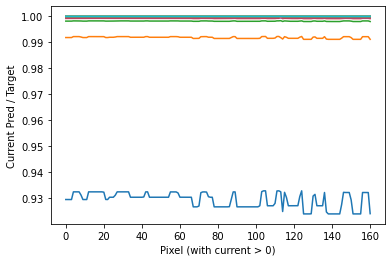

In [43]:
%matplotlib inline

for ic, current in enumerate(training_step_currents):
    plt.plot(current[currents_target > 0].numpy()/currents_target[currents_target > 0].detach().numpy(), 
             label='eField = %.2f' % training_step_eFields[ic])

plt.xlabel('Pixel (with current > 0)')
plt.ylabel('Current Pred / Target')

plt.show()